In [12]:
import pandas as pd
import numpy as np
import random as rnd
import scipy as sp
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from tensorflow.keras.layers import Dense
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import recall_score, f1_score, confusion_matrix
from scipy.stats import boxcox

In [2]:
df_ml=pd.read_csv('C:\\Boot Camp\Homework\\final-project\\data\\ML_data.csv')
df_ml.head()

,loan_amnt,int_rate,emp_length,annual_inc,dti,loan_status,total_pymnt,fico_range_high,home_ownership_MORTGAGE,home_ownership_NONE,home_ownership_OTHER,home_ownership_OWN,home_ownership_RENT
0,54.031941,0.1065,10.0,24000.0,27.65,1,5863.155187,0.095579,0,0,0,0,1
1,41.725612,0.1527,0.0,30000.0,1.00,0,1014.530000,0.095579,0,0,0,0,1
2,41.090191,0.1596,10.0,12252.0,8.72,1,3005.666844,0.095579,0,0,0,0,1
3,69.736321,0.1349,10.0,49200.0,20.00,1,12231.890000,0.095579,0,0,0,0,1
4,44.677641,0.1269,1.0,80000.0,17.94,1,4066.908161,0.095579,0,0,0,0,1


In [3]:
df_ml=df_ml.dropna()

In [4]:
# Set features. This will also be used as your x values.
X = df_ml.drop("loan_status", axis=1)
y=df_ml["loan_status"]
print(X.shape, y.shape)

(1743060, 12) (1743060,)


In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.3, stratify=y)

In [18]:
model = RandomForestClassifier(n_estimators=50).fit(X_train, y_train)

In [19]:
predict = model.predict(X_test)

In [20]:
# recall score
recall_score(y_test, predict)

0.9989725420726306

In [21]:
f1_score(y_test, predict)

0.9867274496126021

(0.0, 2.0, 2.0, 0.0)

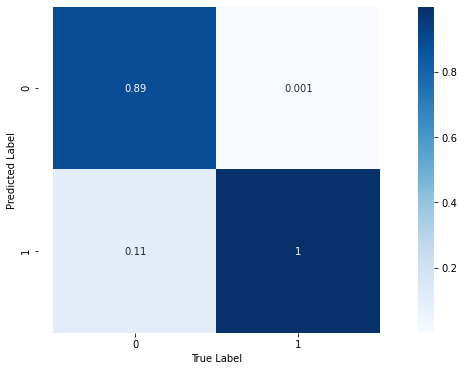

In [12]:
fig, axes = plt.subplots(figsize=(8,6))
cm = confusion_matrix(y_test, predict).T
cm = cm.astype('float')/cm.sum(axis=0)
ax = sns.heatmap(cm, annot=True, cmap='Blues')
ax.set_xlabel('True Label')
ax.set_ylabel('Predicted Label')
ax.axis('equal')

In [14]:
#Let's find the optimum number of estimators for this model and use that for prediction
params = {'n_estimators': [100]}
grid_search = GridSearchCV(RandomForestClassifier(), param_grid=params,
                                   scoring='accuracy', cv=5, n_jobs=-1)
grid_search.fit(X_train, y_train)
print(grid_search.best_params_)
print(grid_search.best_score_)

{'n_estimators': 100}
0.97784028403862


In [20]:
#using 70% data for training and 30% for testing.
traindata, testdata = train_test_split(df_ml, stratify=df_ml['loan_status'],test_size=.3, random_state=17)
testdata.reset_index(drop=True, inplace=True)
traindata.reset_index(drop=True, inplace=True)

In [21]:
#Balancing the training dataset and creating a new model
y_default = traindata[traindata['loan_status'] == 0]
n_paid = traindata[traindata['loan_status'] == 1].sample(n=len(y_default), random_state=17) #chosing equal amount of 1's

#creating a new dataframe for balanced set
data = y_default.append(n_paid) 

#creating the independent and dependent array
Xbal = data.drop('loan_status', axis=1)
ybal = data['loan_status']

In [22]:
Xte = testdata.drop('loan_status', axis=1)
yte = testdata['loan_status']

In [23]:
#Let's try some models on the train dataset
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB

models = {'LDA': LinearDiscriminantAnalysis(),
          'MNB': MultinomialNB(),
          'RF': RandomForestClassifier(n_estimators=50),
          'LR': LogisticRegression(C=1)}

balset = {}
for i in models.keys():
    scores = cross_val_score(models[i], Xbal - np.min(Xbal) + 1,
                                    ybal, scoring='roc_auc', cv=3)
    balset[i] = scores
    print(i, scores, np.mean(scores))

LDA [0.93746454 0.93823958 0.93958208] 0.9384287324125764
MNB [0.67368864 0.67576588 0.67526323] 0.6749059160443466
RF [0.97819638 0.97903834 0.97989605] 0.979043590565349
LR [0.90496751 0.90387425 0.90411774] 0.9043198314252457


In [24]:
#try to find the optimal number of trees using the gridsearchcv
Xte = testdata.drop('loan_status', axis=1)
model = RandomForestClassifier(n_estimators=100)
model.fit(Xbal, ybal)
predict = model.predict(Xte)

(0.0, 2.0, 2.0, 0.0)

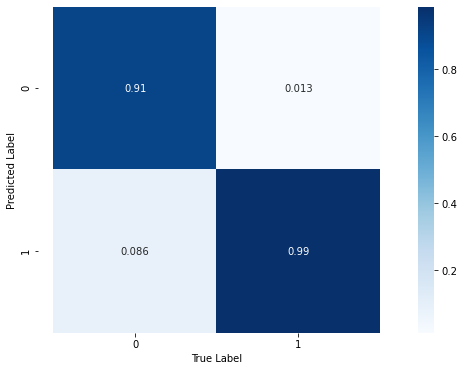

In [25]:
fig, axes = plt.subplots(figsize=(8,6))
cm = confusion_matrix(yte, predict).T
cm = cm.astype('float')/cm.sum(axis=0)
ax = sns.heatmap(cm, annot=True, cmap='Blues')
ax.set_xlabel('True Label')
ax.set_ylabel('Predicted Label')
ax.axis('equal')

In [26]:
#Let's find the optimum number of estimators for this model and use that for prediction
params = {'n_estimators': [50, 100, 200, 400, 600]}
grid_search = GridSearchCV(RandomForestClassifier(), param_grid=params,
                                   scoring='accuracy', cv=5, n_jobs=-1)
grid_search.fit(Xbal, ybal)
print(grid_search.best_params_)
print(grid_search.best_score_)

{'n_estimators': 400}
0.9496377028740761
